# Clinical Note Classification Model Demo

This notebook demonstrates how to use the trained model to classify medical notes and visualize the results.

In [33]:
# Import required libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from src.data_loader import load_and_prepare_data

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Load the Trained Model and Tokenizer

In [35]:
# Load the model and tokenizer
MODEL_PATH = "./results/best_model"
print(f"Loading model from {MODEL_PATH}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Loading model from ./results/best_model...
Using device: cpu


## 2. Load and Prepare Test Data

In [37]:
# Load test data
DATA_PATH = "./data/mtsamples.csv"
raw_datasets, id2label = load_and_prepare_data(DATA_PATH)
test_dataset = raw_datasets['test']

print(f"Number of test samples: {len(test_dataset)}")
print(f"\nAvailable specialties:")
for idx, specialty in id2label.items():
    print(f"{idx}: {specialty}")

Casting the dataset: 100%|██████████| 2353/2353 [00:00<00:00, 51981.17 examples/s]

Number of test samples: 471

Available specialties:
0:  Bariatrics
1:  Cardiovascular / Pulmonary
2:  Neurology
3:  Urology
4:  General Medicine
5:  Surgery
6:  Speech - Language
7:  SOAP / Chart / Progress Notes
8:  Sleep Medicine
9:  Rheumatology
10:  Radiology
11:  Psychiatry / Psychology
12:  Podiatry
13:  Physical Medicine - Rehab
14:  Pediatrics - Neonatal
15:  Pain Management
16:  Orthopedic
17:  Ophthalmology
18:  Office Notes
19:  Obstetrics / Gynecology
20:  Nephrology
21:  Letters
22:  Lab Medicine - Pathology
23:  IME-QME-Work Comp etc.
24:  Hospice - Palliative Care
25:  Hematology - Oncology
26:  Gastroenterology
27:  ENT - Otolaryngology
28:  Emergency Room Reports
29:  Discharge Summary
30:  Dermatology
31:  Cosmetic / Plastic Surgery
32:  Consult - History and Phy.
33:  Chiropractic
34:  Autopsy


## 3. Make Predictions on Test Set

In [38]:
def predict_specialty(text):
    """Make prediction for a single text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id, logits.softmax(dim=1)[0]

# Make predictions
print("Making predictions on test set...")
predictions = []
true_labels = test_dataset['label']

for text in test_dataset['text']:
    pred_id, _ = predict_specialty(text)
    predictions.append(pred_id)

Making predictions on test set...


## 4. Evaluate Model Performance


Classification Report:
                                precision    recall  f1-score   support

                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       0.00      0.00      0.00         5
                     Neurology       0.00      0.00      0.00        14
                       Urology       0.00      0.00      0.00        31
              General Medicine       0.00      0.00      0.00        32
                       Surgery       0.00      0.00      0.00       195
             Speech - Language       0.00      0.00      0.00         2
 SOAP / Chart / Progress Notes       0.00      0.00      0.00        29
                Sleep Medicine       0.00      0.00      0.00         4
                  Rheumatology       0.02      0.50      0.04         2
                     Radiology       0.00      0.00      0.00        50
       Psychiatry / Psychology       0.00      0.00      0.00        10
                      Podiatry       0.

c:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\clinical-nlp-GgmYWmoG-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\clinical-nlp-GgmYWmoG-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8

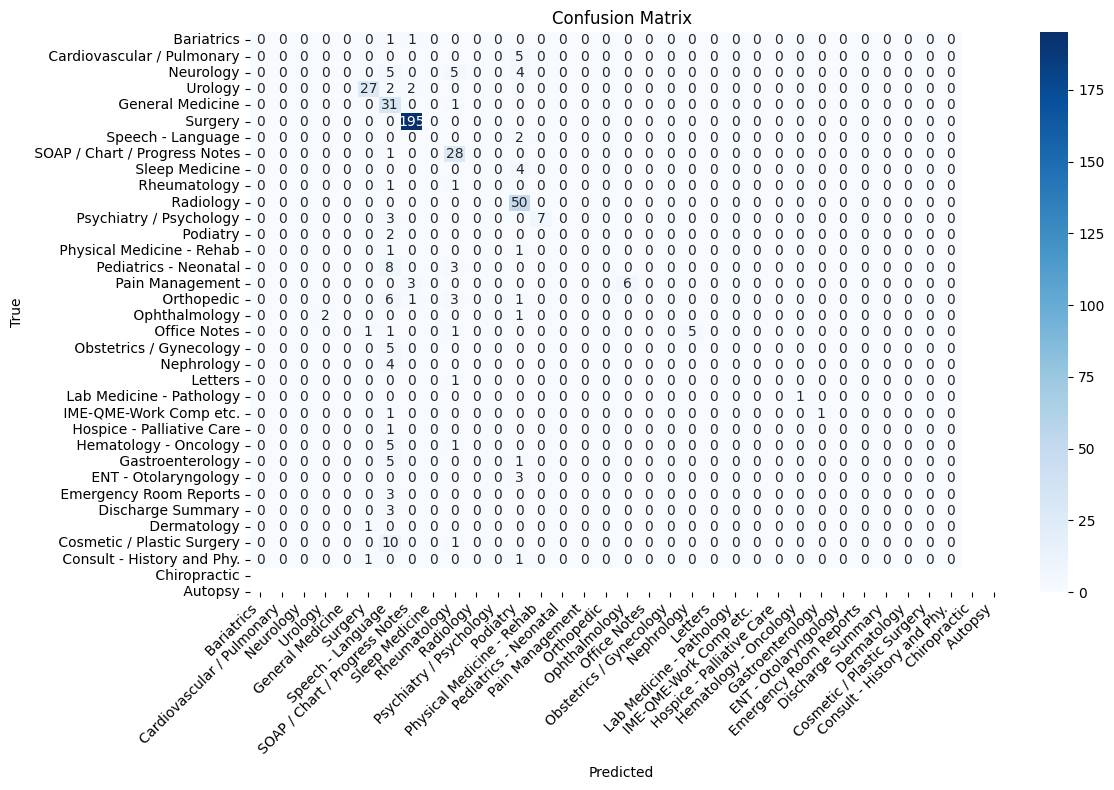

In [39]:
# Get unique labels that are actually present in the data
unique_labels = np.unique(np.concatenate([true_labels, predictions]))
target_names = [id2label[label] for label in unique_labels]

# Generate classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          labels=unique_labels,
                          target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Interactive Demo: Classify Your Own Medical Note

In [ ]:
def classify_note(note_text):
    """Classify a medical note and show prediction probabilities."""
    pred_id, probabilities = predict_specialty(note_text)
    
    # Get top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)
    
    print(f"\nPredicted Specialty: {id2label[pred_id]}")
    print("\nTop 3 Predictions:")
    for prob, idx in zip(top3_prob, top3_idx):
        print(f"{id2label[idx.item()]}: {prob.item():.2%}")

# Example medical notes for testing
example_notes = [
    "Patient presents with severe headache and photophobia. Neurological examination shows normal reflexes. Recommend MRI of the brain to rule out intracranial pathology.",
    "Patient reports chest pain and shortness of breath. EKG shows ST elevation. Troponin levels elevated. Recommend immediate cardiac catheterization.",
    "Patient complains of joint pain and morning stiffness. Physical examination reveals swelling in multiple joints. Rheumatoid factor positive."
]

# Test each example
for i, note in enumerate(example_notes, 1):
    print(f"\nExample {i}:")
    print(f"Note: {note}")
    classify_note(note)


Example 1:
Note: Patient presents with severe headache and photophobia. Neurological examination shows normal reflexes. Recommend MRI of the brain to rule out intracranial pathology.

Predicted Specialty:  Podiatry

Top 3 Predictions:
 Podiatry: 47.62%
 Rheumatology: 4.17%
 Urology: 3.87%

Example 2:
Note: Patient reports chest pain and shortness of breath. EKG shows ST elevation. Troponin levels elevated. Recommend immediate cardiac catheterization.

Predicted Specialty:  Podiatry

Top 3 Predictions:
 Podiatry: 47.41%
 SOAP / Chart / Progress Notes: 5.26%
 Rheumatology: 4.20%

Example 3:
Note: Patient complains of joint pain and morning stiffness. Physical examination reveals swelling in multiple joints. Rheumatoid factor positive.Patient has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two blocks or five flights of

KeyError: 36

## 6. Analyze Model Confidence

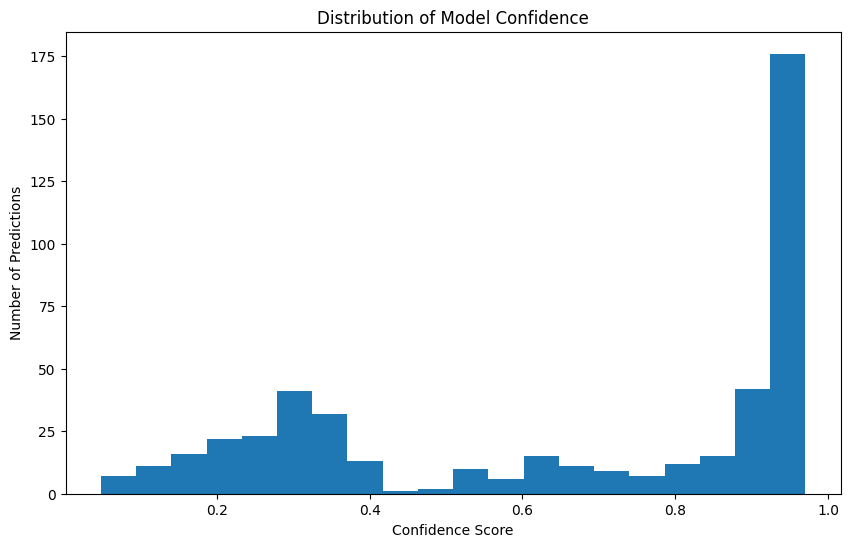

ValueError: not enough values to unpack (expected 2, got 0)

<Figure size 1200x600 with 0 Axes>

In [42]:
# Calculate prediction probabilities for test set
all_probabilities = []
for text in test_dataset['text']:
    _, probs = predict_specialty(text)
    all_probabilities.append(probs.cpu().numpy())

all_probabilities = np.array(all_probabilities)

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(np.max(all_probabilities, axis=1), bins=20)
plt.title('Distribution of Model Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Predictions')
plt.show()

# Calculate average confidence by specialty
avg_confidence = []
for specialty in range(len(id2label)):
    mask = true_labels == specialty
    if np.any(mask):
        conf = np.mean(np.max(all_probabilities[mask], axis=1))
        avg_confidence.append((id2label[specialty], conf))

avg_confidence.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
specialties, confidences = zip(*avg_confidence)
plt.bar(specialties, confidences)
plt.title('Average Model Confidence by Specialty')
plt.xlabel('Specialty')
plt.ylabel('Average Confidence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()